In [264]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

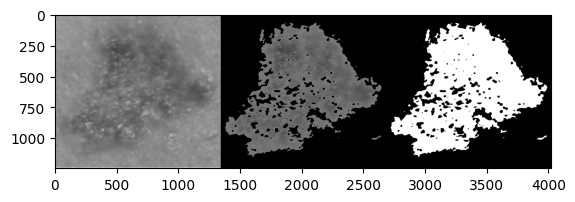

In [265]:
# STEP 1 & 2: Preparing the image, thresholding to identify the area of the lesion

# Instead of choosing one channel, the grayscale is made from the average of each one
original_image = cv.imread('cancer.png', cv.IMREAD_GRAYSCALE)


_, thresh_mask = cv.threshold(original_image, 0, 255, cv.THRESH_OTSU)

# STEP 3: Applying the mask to the original image
#inverse of image
thresh_mask = 255 - thresh_mask

# We use the already inverted mask, converting it to ones
# and multiply it by the original, to show how the
# relevant information remains

filterer = thresh_mask.copy() / 255
filtered = original_image * filterer

plt.imshow(np.hstack([original_image, filtered, thresh_mask]), cmap='gray')


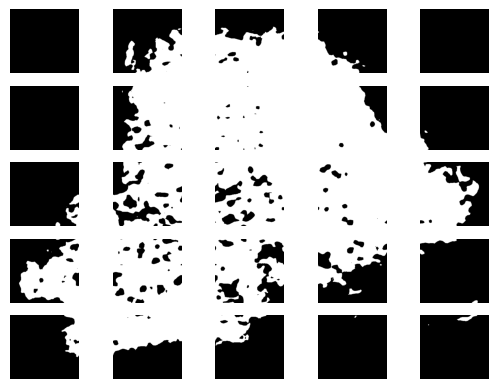

In [266]:
# STEP 4: Dividing the image into 25 subimages

# extract subimages
height, width = original_image.shape

# Calculate the number of rows and columns for the 5x5 grid
rows = 5
cols = 5

# Calculate the size of each sub-image
sub_image_height = height // rows
sub_image_width = width // cols

# Initialize a list to store sub-images
# filtered_sub_images have the mask applied to the original image, and are divided into 25 subimages
filtered_sub_images = []
# mask sub images have only the mask, and are divided into 25 subimages
mask_sub_images = []

# Iterate through each row and column to extract sub-images
for i in range(rows):
    for j in range(cols):
        # Calculate the starting and ending indices for each sub-image
        start_row = i * sub_image_height
        end_row = start_row + sub_image_height
        start_col = j * sub_image_width
        end_col = start_col + sub_image_width

        # Extract the sub-image from the original image
        sub_image = thresh_mask[start_row:end_row, start_col:end_col]
        sub_image_filtered = filtered[start_row:end_row, start_col:end_col]

        # Append the sub-image to the list
        mask_sub_images.append(sub_image)
        filtered_sub_images.append(sub_image_filtered)

        # Optionally, you can display each sub-image using pyplot
        plt.subplot(rows, cols, i * cols + j + 1)
        plt.imshow(sub_image, cmap='gray', vmin=0, vmax=255)
        plt.axis('off')

# Show the plot with sub-images
plt.show()

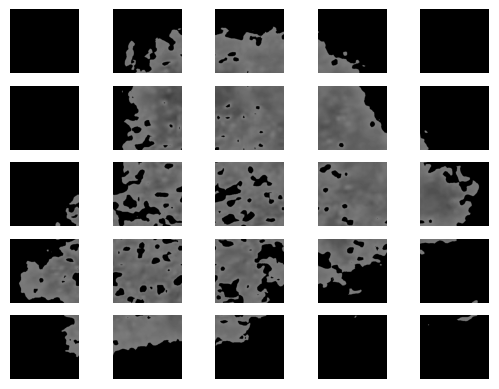

In [267]:

a = 0
for i in range(rows):
    for j in range(cols):
        plt.subplot(rows, cols, i * cols + j + 1)
        plt.imshow(filtered_sub_images[a], cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
        a += 1


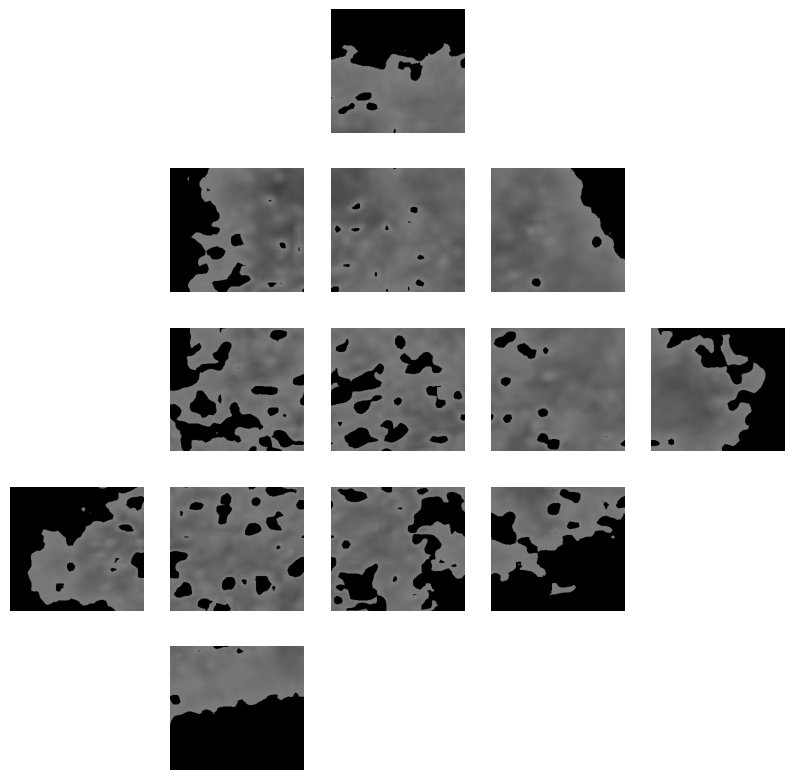

In [283]:
# STEP 5: Selecting the sub-images that contain the lesion, discarding 
# the ones with less than one-third of the area of the sub-image

# Initialize a list to store the selected sub-images
# This list is used for the pretty visualization
selected_sub_images = []
# This lists are used for the calculations
selected_sub_images_without_blanks = []
mask_sub_images_without_blanks = []

# Iterate through each pair of filtered and mask sub-images
for filtered_sub_image, mask_sub_image in zip(filtered_sub_images, mask_sub_images):
    # Calculate the area of the mask region in the sub-image
    mask_area = np.sum(mask_sub_image > 0)

    # Calculate the threshold based on one-third of the total area of the sub-image
    threshold = (1/3) * np.prod(filtered_sub_image.shape[:2])

    # Check the condition and select the sub-image if the condition is met
    if mask_area >= threshold:
        selected_sub_images.append(filtered_sub_image)
        selected_sub_images_without_blanks.append(filtered_sub_image)
        mask_sub_images_without_blanks.append(mask_sub_image)
    else:
        selected_sub_images.append(np.ones_like(filtered_sub_image)*255)

# Originally the mask is of values of 0 or 255, but for the final calculations we need 0 or 1
mask_sub_images_without_blanks = list(map(lambda x: x/255,mask_sub_images_without_blanks))

# Display the selected sub-images using pyplot
rows = 5
cols = 5

plt.figure(figsize=(10, 10))

for i, sub_image in enumerate(selected_sub_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sub_image, vmin=0, vmax=255, cmap='gray')
    plt.axis('off')

plt.show()


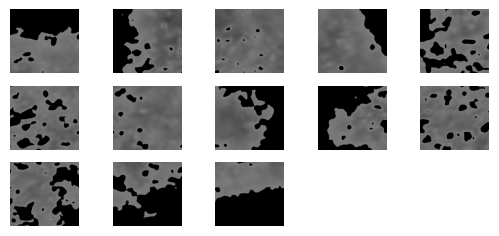

In [284]:
# Show only the selected sub-images without the blanks
for i, sub_image in enumerate(selected_sub_images_without_blanks):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sub_image, vmin=0, vmax=255, cmap='gray')
    plt.axis('off')

plt.show()


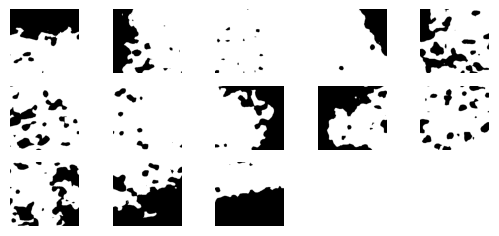

In [292]:
# Show only the mask sub-images without the blanks
for i, sub_image in enumerate(mask_sub_images_without_blanks):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sub_image, vmin=0, vmax=1, cmap='gray')
    plt.axis('off')

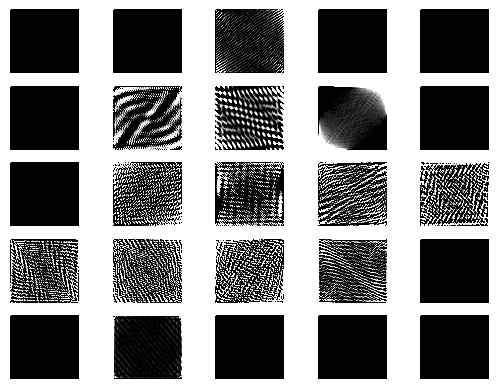

In [304]:
# STEP 6 & 7: The filter is applied to each sub-image

# This functions perform the Classical Matched Filter as described in the paper
# from which this code is based on
def classical_matched_filter(image):
    # Compute the Fourier transform of the input image
    fft_image = np.fft.fft2(image)
    fft_shifted_image = np.fft.fftshift(fft_image)

    # Compute the magnitude and phase of the Fourier transform
    magnitude = np.abs(fft_shifted_image)
    phase = np.angle(fft_shifted_image)

    # Create the classical matched filter
    classical_matched_filter = magnitude * np.exp(1j * phase)

    return classical_matched_filter
    
# The final applying the shifts stay the same, only the visualization changes
def classical_matched_filter_without_shift(image):
    # Compute the Fourier transform of the input image
    fft_image = np.fft.fft2(image)

    # Compute the magnitude and phase of the Fourier transform
    magnitude = np.abs(fft_image)
    phase = np.angle(fft_image)

    # Create the classical matched filter
    classical_matched_filter = magnitude * np.exp(1j * phase)

    return classical_matched_filter
    
selected_sub_images_after_classical_matched_filter = list(map(classical_matched_filter_without_shift, selected_sub_images))
selected_sub_images_after_classical_matched_filter_without_blanks = list(map(classical_matched_filter_without_shift, selected_sub_images_without_blanks))
    
for i, sub_image in enumerate(selected_sub_images_after_classical_matched_filter):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sub_image.real, vmin=0, vmax=255, cmap='gray')
    plt.axis('off')

plt.show()


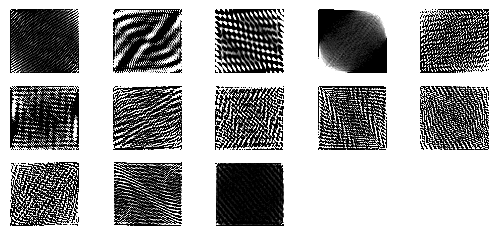

In [305]:
for i, sub_image in enumerate(selected_sub_images_after_classical_matched_filter_without_blanks):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sub_image.real, vmin=0, vmax=255, cmap='gray')
    plt.axis('off')

plt.show()


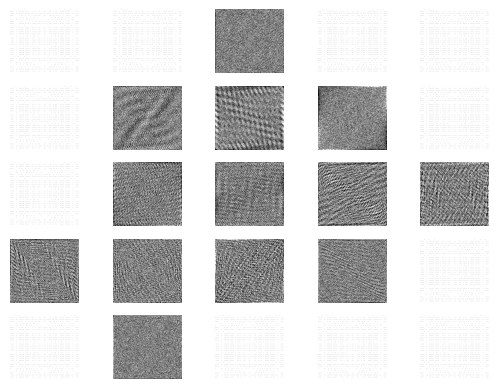

In [310]:
# STEP 8: Binarizing the images to get the spectral density

def binarize_image(fourier_transform):
    # Get the real and imaginary parts of the Fourier transform
    real_part = np.real(fourier_transform)
    imaginary_part = np.imag(fourier_transform)

    # Create a binary mask based on the conditions
    binary_mask = np.where(real_part >= 0, 1, 0)

    return binary_mask

selected_sub_images_after_binarization = list(map(binarize_image, selected_sub_images_after_classical_matched_filter))
selected_sub_images_after_binarization_without_blanks = list(map(binarize_image, selected_sub_images_after_classical_matched_filter_without_blanks))

for i, sub_image in enumerate(selected_sub_images_after_binarization):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sub_image, vmin=0, vmax=1, cmap='gray')
    plt.axis('off')


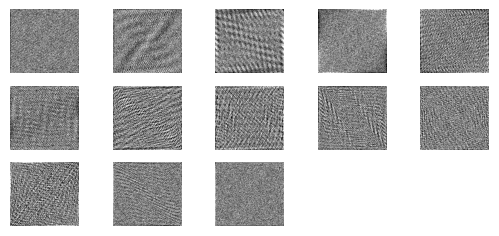

In [311]:

for i, sub_image in enumerate(selected_sub_images_after_binarization_without_blanks):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sub_image, vmin=0, vmax=1, cmap='gray')
    plt.axis('off')


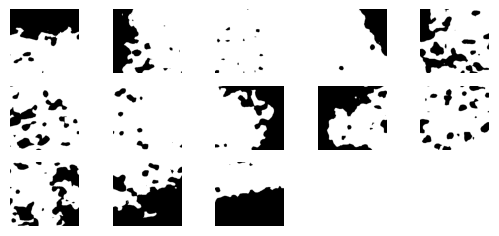

In [312]:
for i, sub_image in enumerate(mask_sub_images_without_blanks):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sub_image, vmin=0, vmax=1, cmap='gray')
    plt.axis('off')


In [313]:
# STEP 9: Calculating the spectral index of each sub-image

def spectral_index_sub_image(after_binarization_sub_image, thresh_mask_sub_image):
    # Calculate the sum of unit values for each mask
    sum_binary_mask = np.sum(after_binarization_sub_image)
    sum_thresh_mask = np.sum(thresh_mask_sub_image)

    # Calculate the spectral index
    index = sum_binary_mask / sum_thresh_mask
    return index

def zip_with(func, list1, list2):
    return [func(a, b) for a, b in zip(list1, list2)]

# Finally the spectral index of the image analyzed is obtained by averaging the indices
spectral_indeces_of_sub_images_without_blanks = zip_with(spectral_index_sub_image, selected_sub_images_after_binarization_without_blanks, mask_sub_images_without_blanks)

for i, ind in enumerate(spectral_indeces_of_sub_images_without_blanks):
    print(f'Spectral index of sub-image {i}: {ind}')

# STEP 10: Calculating the spectral index of all the image
spectral_index = np.mean(spectral_indeces_of_sub_images_without_blanks)
print(f'\n\nSpectral index of the image: {spectral_index}')

Spectral index of sub-image 0: 0.86628923269587
Spectral index of sub-image 1: 0.7189193877108538
Spectral index of sub-image 2: 0.5112259880092989
Spectral index of sub-image 3: 0.6172828264432708
Spectral index of sub-image 4: 0.7021709486807645
Spectral index of sub-image 5: 0.5964840556009812
Spectral index of sub-image 6: 0.5241181504135898
Spectral index of sub-image 7: 0.8638254981521205
Spectral index of sub-image 8: 0.945431581364641
Spectral index of sub-image 9: 0.5845111326234269
Spectral index of sub-image 10: 0.7300327985107703
Spectral index of sub-image 11: 1.1718133107727016
Spectral index of sub-image 12: 1.0760262092888804


Spectral index of the image: 0.7621639323282439


In [314]:
def calc_

SyntaxError: expected '(' (3065788976.py, line 1)